#### Imports

In [249]:
# All imports will be here

import numpy as np
import pandas as pd
import os
import email 
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
import re
import urlextract
import cleantext
from scipy.sparse import csr_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split


#### Methods

In [70]:
# All functions will be defined here

def parse_email(dir, fname):
    with open(os.path.join(dir, fname), 'rb') as m:
        return email.parser.BytesParser().parse(m)
    
def get_struct(mail): # get emails structures
    payload = mail.get_payload()
    structs = []
    if isinstance(payload, list):
        for msg in payload:
            structs.append(get_struct(msg))
        return f'Multipart({structs})'
    else:
        return mail.get_content_type()
    
def structs_counter(mails):
    cnt = Counter()
    for mail in mails:
        struct = get_struct(mail)
        cnt[struct] += 1

    return cnt

def draw_word_cloud(structs):
    word_cloud = WordCloud(width=1600, height=800)
    word_cloud.generate_from_frequencies(frequencies=structs)

    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()

def html_to_plain(mail):
    soup = BeautifulSoup(mail.get_payload(), "html.parser")
    plain = soup.text.replace("=\n", "")
    plain = re.sub(r"\s+", " ", plain)
    
    return plain.strip()

def mail_to_plain(mail):
    txt_cont = ''
    for part in mail.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']: continue
        if part_content_type == 'text/plain':
            txt_cont += part.get_payload()
        else:
            txt_cont += html_to_plain(part)

    return txt_cont

def email_subject(mail):
    return mail['subject']

#### Transformers

In [199]:
class WordCounterTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        stemmer = nltk.PorterStemmer()
        url_extractor = urlextract.URLExtract()
        X_transformed = []
        
        for mail in X:
            txt: str = mail_to_plain(mail)
            if txt is None:
                txt = 'nothing'
            txt = txt.lower()

            urls = url_extractor.find_urls(txt)
            for url in urls: # replace any url with "URL"
                txt = txt.replace(url, ' URL ')

            txt = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', txt) # replace any number with "NUMBER"

            txt = cleantext.replace_emails(txt, replace_with="MAIL")    # repace any email with "EMAIL"

            txt = re.sub(r'\W+', ' ', txt, flags=re.M) # remove punctuation

            for word in txt.split(): # stem words (TO BE REVISED)
                stemmed = stemmer.stem(word, to_lowercase=False)
                txt = txt.replace(word, stemmed)

            word_counts = Counter(txt.split())
            X_transformed.append(word_counts)

        return X_transformed


class WordCountVectorizerTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size

    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
                
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        
        return self
    
    def transform(self, X, y=None):
        rows, cols, data = [], [], []

        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)

        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [3]:
ham_fnames = [mail for mail in os.listdir('/media/elneklawy/extra/emails/main_ham')]
spam_fnames = [mail for mail in os.listdir('/media/elneklawy/extra/emails/main_spam')]

In [4]:
ham_dir = '/media/elneklawy/extra/emails/main_ham'
spam_dir = '/media/elneklawy/extra/emails/main_spam'

hams = [parse_email(ham_dir, mail) for mail in ham_fnames]
spams = [parse_email(spam_dir, mail) for mail in spam_fnames]

In [5]:
print(f'Number of ham emails: {len(hams)}\nNumber of spam emails: {len(spams)}\nSpam ratio: {round(len(spams)/(len(spams)+len(hams)) * 100, 3)}%')

Number of ham emails: 6951
Number of spam emails: 2398
Spam ratio: 25.65%


In [6]:
tst_email = hams[0]
tst_email

In [7]:
print(f'Header names: {tst_email.keys()}\nField values: {tst_email.values()}\nContent: {tst_email.get_payload()}')

Header names: ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'X-Authentication-Warning', 'Received', 'Received', 'Date', 'From', 'To', 'Subject', 'Message-Id', 'References', 'MIME-Version', 'Content-Type', 'Content-Disposition', 'User-Agent', 'In-Reply-To', 'Sender', 'Errors-To', 'X-Mailman-Version', 'Precedence', 'List-Id', 'X-Beenthere']
Field values: ['<ilug-admin@linux.ie>', 'zzzz@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 8E6C243F99\n\tfor <zzzz@localhost>; Wed, 28 Aug 2002 05:47:23 -0400 (EDT)', 'from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Wed, 28 Aug 2002 10:47:23 +0100 (IST)', 'from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7RJaWZ22801 for\n    <zzzz-ilug@spamassassin.taint.org>; Tue, 27 Aug 2002 20:36:32 +0100', 'from lug

In [8]:
for mail in hams:
    if mail.is_multipart():
        multi_mail = mail
        break

print(multi_mail.get_payload(), multi_mail.get_payload()[0].get_payload(), multi_mail.get_payload()[1].get_payload(), sep='\n\n')

# The payload of a multipart email is a list of email.message.Message instances (non-leaf nodes).
# We need to traverse the tree of a multipart email upto its leaf node to get the actual content, the part contains.

[<email.message.Message object at 0x7fe58a290310>, <email.message.Message object at 0x7fe58a291c30>]

Made me chuckle.

http://www.bloggerheads.com/can_weblogs/ronald_scelson.asp

rOD.

--
"Don't frown, don't pout, don't snivel, don't cry,
 Don't cough, don't choke, don't faint, don't die."

>> Doing the blogging thang again at http://www.groovymother.com/ <<



MIAGCSqGSIb3DQEHAqCAMIACAQExCzAJBgUrDgMCGgUAMIAGCSqGSIb3DQEHAQAAoIIJIjCCAnow
ggHjoAMCAQICARcwDQYJKoZIhvcNAQEFBQAwUzELMAkGA1UEBhMCVVMxHDAaBgNVBAoTE0VxdWlm
YXggU2VjdXJlIEluYy4xJjAkBgNVBAMTHUVxdWlmYXggU2VjdXJlIGVCdXNpbmVzcyBDQS0xMB4X
DTAyMDQxODE1MjkzN1oXDTIwMDQxMzE1MjkzN1owTjELMAkGA1UEBhMCVVMxFjAUBgNVBAoTDUdl
b1RydXN0IEluYy4xJzAlBgNVBAMTHkdlb1RydXN0IFRydWUgQ3JlZGVudGlhbHMgQ0EgMjCBnzAN
BgkqhkiG9w0BAQEFAAOBjQAwgYkCgYEAspcspZISpYX/aJqWoYcSyyGqFby3OvsepRzLRU0ENDJR
wJo7DwFpirRFOUQkTkKXsY6BQzX/CeCRrn9i4ny5gcXuI2JSyrSmDwobbwl52n5cPEbHGcebybWd
KfAf8vvkxYUnTmDZPtt2ob5RNpJTeTiq9MpNCB/5G7Ocr1hEljcCAwEAAaNjMGEwDgYDVR0PAQH/
BAQDAgHGMB0GA1UdDgQ

In [9]:
tst_email.get_content_type(), multi_mail.get_content_type()

('text/plain', 'multipart/signed')

In [10]:
get_struct(multi_mail)

"Multipart(['text/plain', 'application/x-pkcs7-signature'])"

In [11]:
hams_structs = structs_counter(hams)
spams_structs = structs_counter(spams)

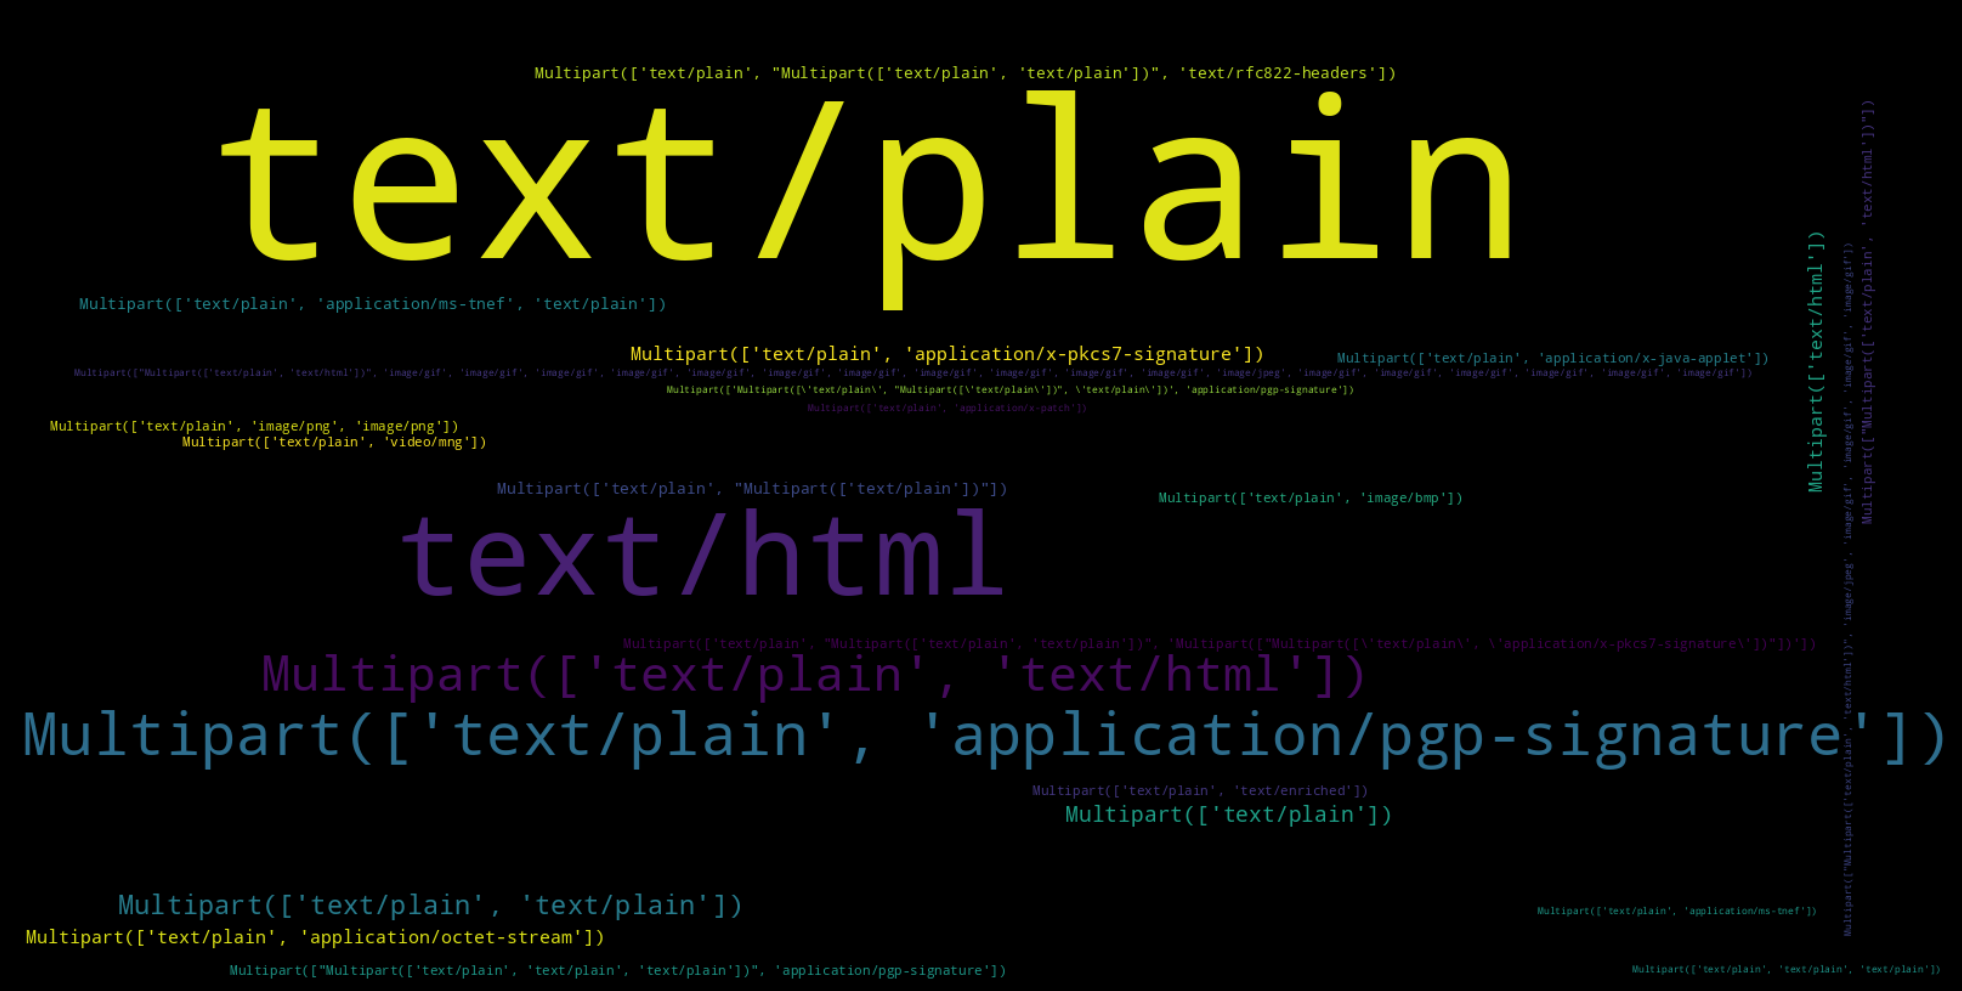

In [12]:
draw_word_cloud(hams_structs)

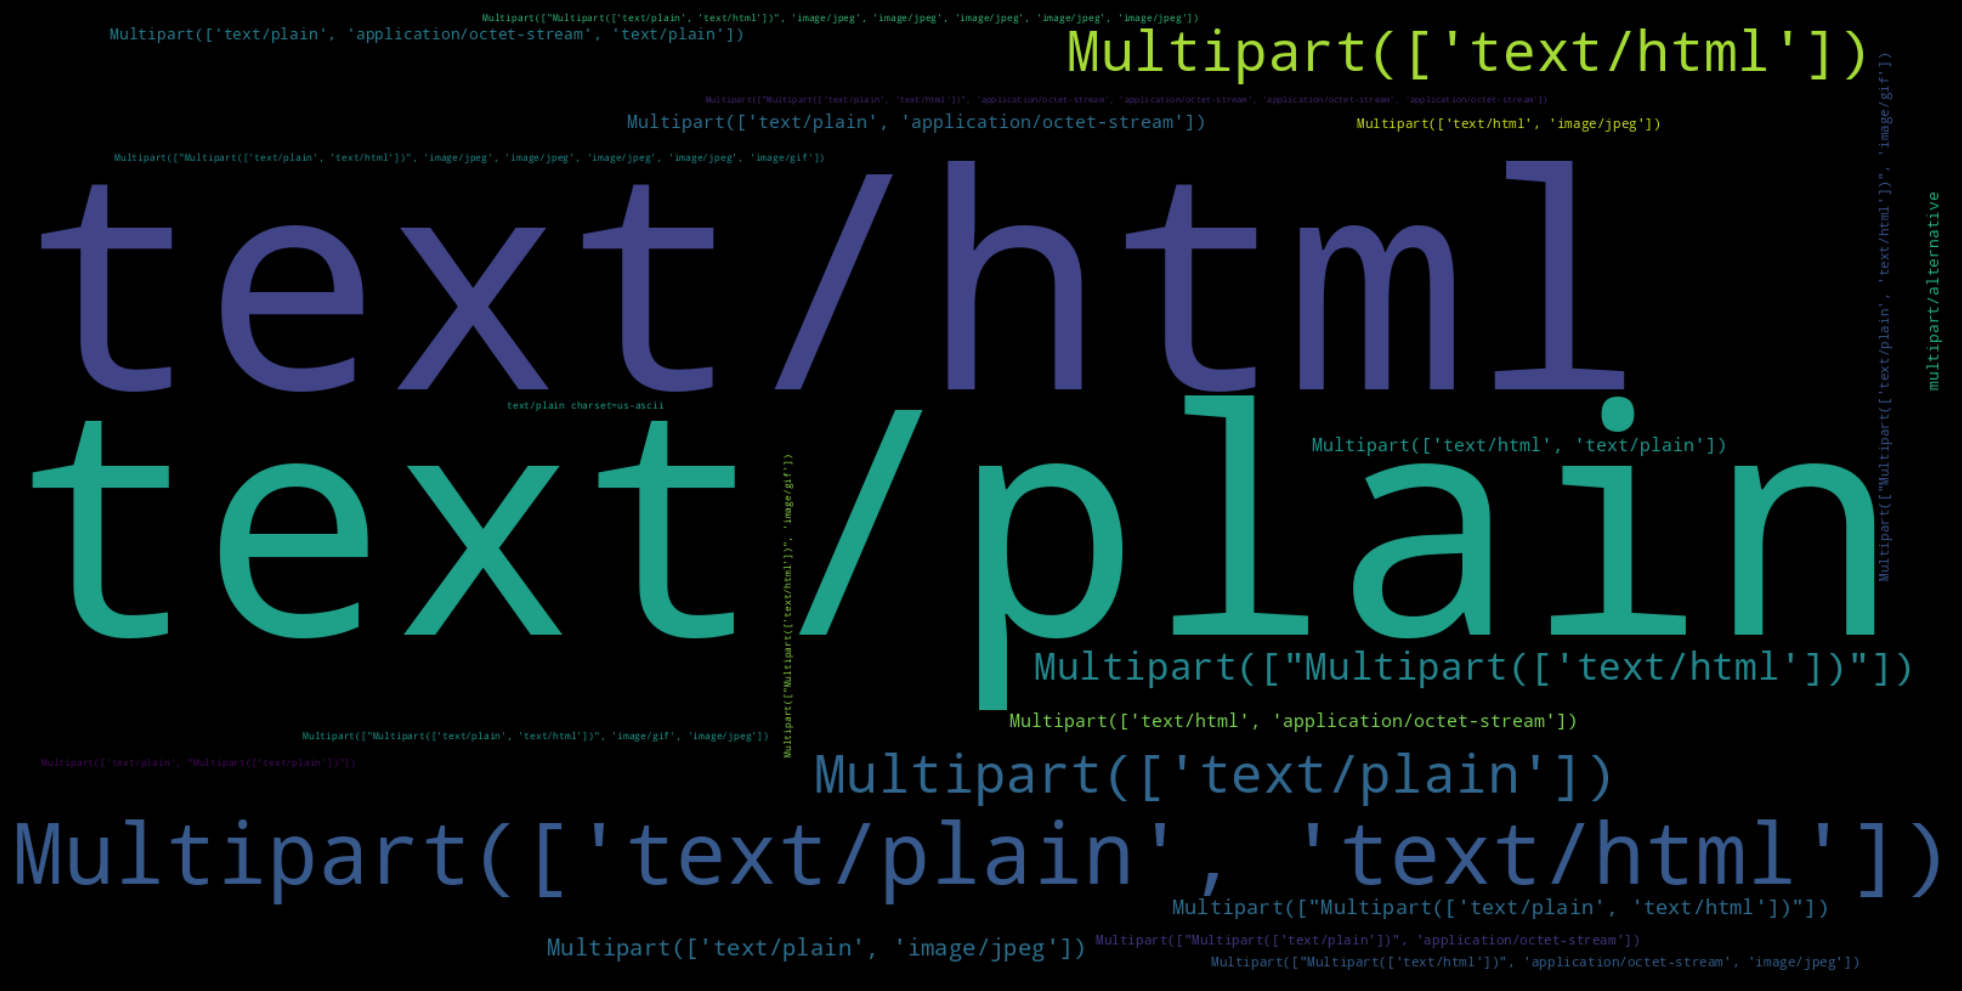

In [13]:
draw_word_cloud(spams_structs)

#### Data Cleaning

HTML emails must be converted into plain text in order for the ML algorithms to work with them

In [14]:
# example html mail

for mail in hams:
    if get_struct(mail) == 'text/html':
        html_mail = mail
        break

print(html_mail.get_payload())


<html>
<head>
	<title>CNET Shopper Newsletter: MAC Edition</title>

</head>
<body bgcolor="#EEEEEE" alink="#0000FF" vlink="#0000FF">

<div align="center">

<A href="top"></A><!-- header -->
	<table cellpadding=0 cellspacing=0 border=0 width=612 bgcolor="#ffffff">
	<tr valign=top>
		<td width=442 colspan=4>
			<img src="http://www.cnet.com/i/nl/sh/hd_mac.gif" width="442" height="60" border="0" alt="CNET Shopper Mac Edition"><br>
				<table width=442 cellpadding=0 cellspacing=0 border=0 bgcolor="#ffcc00">
					<tr>
						<td bgcolor="#000000" colspan=3>
							<img src="http://home.cnet.com/b.gif" width="1" height="1" border="0"><br>
						</td>
					</tr>
					<tr>
						<td bgcolor="#000000" width=1 rowspan=2>
							<img src="http://home.cnet.com/b.gif" width="1" height="10" border="0"><br>
						</td>
						<td width=10 rowspan=2>
							<img src="http://home.cnet.com/b.gif" width="1" height="10" border="0"><br>
						</td>
						<td  width=430>
							<img src="http://home.cnet.com

In [15]:
print(mail_to_plain(html_mail))

CNET Shopper Newsletter: MAC Edition Shopper All CNET The Web 1 Cyber Shot DSC-F707 2 Canon PowerShot S40 3 Palm m515 4 Nikon Coolpix 995 5 Canon PowerShot G2 All most popular Live tech help NOW! April's tech award 1 million open jobs News.com: Top CIOs ZDNet: PeopleSoft Dear Reader, Is your Mac acting a bit sluggish? Does is sometimes choke on large graphics files or spend more time than ever spinning its hard drive? Adding more RAM to your Mac is an easy way to get the most out of your favorite game and graphics applications. But unfortunately, figuring out what type to buy is often both difficult and frustrating. CNET's all-in-one Memory Configurator makes finding the perfect memory easy! Whether you're searching for iBook, iMac, or PowerBook memory, your just a few clicks away from the upgrade you'll need to get your system living up to its full potential. Check out CNET's new Memory Configurator Apple iMac • PowerPC G4, 800MHz • DVD-CDRW • 256MB RAM, 60GB hard drive Just $1,805 Ap

In [16]:
print(mail_to_plain(multi_mail))

Made me chuckle.

http://www.bloggerheads.com/can_weblogs/ronald_scelson.asp

rOD.

--
"Don't frown, don't pout, don't snivel, don't cry,
 Don't cough, don't choke, don't faint, don't die."

>> Doing the blogging thang again at http://www.groovymother.com/ <<




In [17]:
print(mail_to_plain(tst_email))

Inn Share's [shareinnn@yahoo.com] 22 lines of wisdom included:
> 
> Hi,all:
> 
> Does anyone know how to list the biggest file in my
> root directory?or the second biggest ..etc...
> 
> Because I want to find out what is the reason cause my
> root all most full.

$ find /dir -name \*  | xargs du -s | sort -n

Smallest files are listed first with the largest at the end. So if
you want to get the 5 largest files, pipe through tail.

e.g.

$ find /dir -name \*  | xargs du -s | sort -n | tail -5
-- 
  Philip Reynolds        
   RFC Networks          tel: 01 8832063
www.rfc-networks.ie      fax: 01 8832041

-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie




In [51]:
hams_subjects = [email_subject(mail) for mail in hams]
spams_subjects = [email_subject(mail) for mail in spams]

In [75]:
stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [77]:
url_extractor = urlextract.URLExtract()
url_extractor.find_urls(mail_to_plain(tst_email))

['www.rfc-networks.ie', 'http://www.linux.ie/mailman/listinfo/ilug']

In [200]:
X_few = hams[:3]
X_few_wordcounts = WordCounterTransformer().fit_transform(X_few)
vocab_transformer = WordCountVectorizerTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [201]:
X_few_vectors.toarray()

array([[ 85,   6,   3,   0,   7,   0,   3,   3,   3,   1,   2],
       [144,   7,   7,   1,   1,   0,   4,   3,   2,   4,   1],
       [ 17,   1,   0,   8,   0,   8,   0,   0,   0,   0,   2]])

#### Creating Train and Test Data

In [233]:
X = np.array(hams + spams, dtype=object)
y = np.array([0] * len(hams) + [1] * len(spams))

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

#### Pipelining

In [263]:
preprocessing = Pipeline([
    ('word_counter', WordCounterTransformer()),
    ('vectorize', WordCountVectorizerTransformer())
])

In [264]:
X_train_transformed = preprocessing.fit_transform(X_train)